## Team Members:
#### Binlin Chi  
#### Hanyuan Hu

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = 20, 10

In [2]:
from sklearn.naive_bayes import *
from sklearn.ensemble import *

Intel(R) Data Analytics Acceleration Library (Intel(R) DAAL) solvers for sklearn enabled: https://intelpython.github.io/daal4py/sklearn.html


In [3]:
from naive_bayes_classifier.load_data import str2word_bag
from naive_bayes_classifier.configure import *
from back_test import *
from utils import *

In [4]:
import pickle
import pandas as pd
import numpy as np
import datetime as dt

## 1. Accquiring Speeches From the Fed's Website

Using web crawler, can be found in *data_crawler.py*

In [5]:
rate_se, rst_lst = load_data()

rst_lst[:1]

## 2. Five-Year Real Treasury Yield (from 2004 til Now)  

In [6]:
def display_impactful_speech(rst_lst_=rst_lst, rates = rate_se, time_window=10, show_ratio=0.2):
    speech_dates = pd.to_datetime([rst_lst[i][1] for i in range(len(rst_lst))])
    speech_dates = pd.Series(speech_dates)
    speech_dates.sort_values(inplace=True)
    speech_dates = speech_dates.reset_index(drop=True).reindex(index=speech_dates)
    
    vol_after_speech = speech_dates.copy()
    for date in speech_dates.index:
        vol = np.std(rates[date:date+dt.timedelta(days=time_window)])
        vol_after_speech[date] = vol
        
    vol_after_speech = vol_after_speech.sort_values(ascending=False)
    dates_to_display = vol_after_speech[:int(len(vol_after_speech)*show_ratio)].index
    plt.scatter(dates_to_display, rates[dates_to_display], color='red', marker='^')
    
    list_y = []
    for date in dates_to_display:
        list_y.append(min(rate_se)-0.2)
    plt.scatter(dates_to_display, list_y, color='red', marker='^')

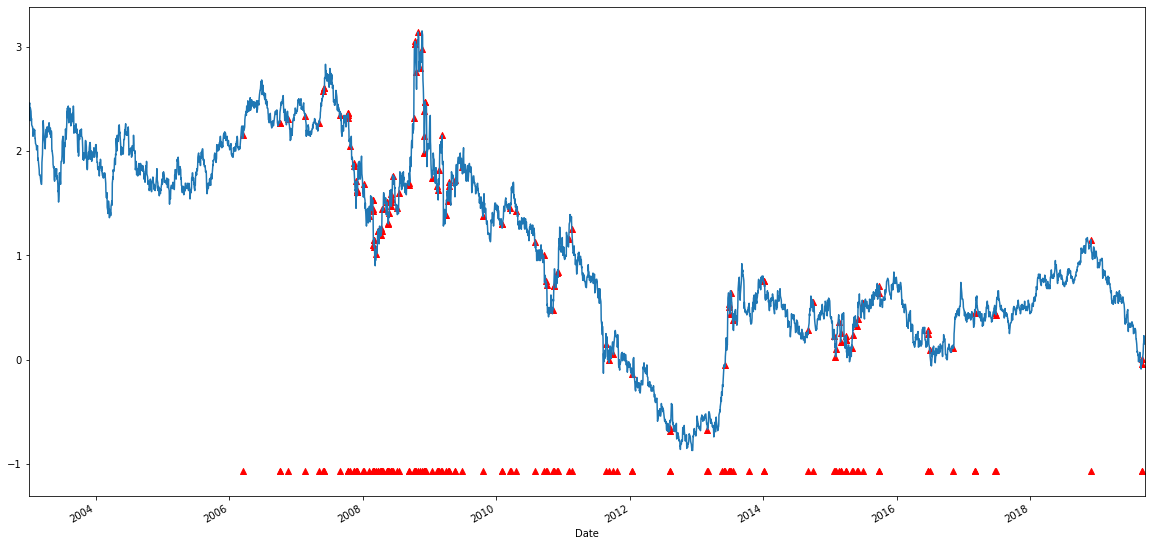

In [7]:
rate_se.plot();
display_impactful_speech(show_ratio=0.2)

## 3. Overall Reval Profile 

Reval/preval analysis is a widely used tools in market impact analysis. It is defined as the price movement before and after a certain incident happens in the market. In this case study, we construct revals of 5-year treasury yield movement before and after Fed speeches. 

In [8]:
rev_lst = get_reval(rst_lst, rate_se)

C:\Users\hoore\Documents\workspace\nlp_project\utils.py:33: RuntimeWarning: divide by zero encountered in log
  tt = np.log(np.hstack((prev, rev)) / this)
C:\Users\hoore\Documents\workspace\nlp_project\utils.py:33: RuntimeWarning: invalid value encountered in log
  tt = np.log(np.hstack((prev, rev)) / this)
C:\Users\hoore\Documents\workspace\nlp_project\utils.py:33: RuntimeWarning: divide by zero encountered in true_divide
  tt = np.log(np.hstack((prev, rev)) / this)
C:\Users\hoore\Documents\workspace\nlp_project\utils.py:33: RuntimeWarning: invalid value encountered in true_divide
  tt = np.log(np.hstack((prev, rev)) / this)


In [9]:
rev_ar = np.vstack(rev_lst)

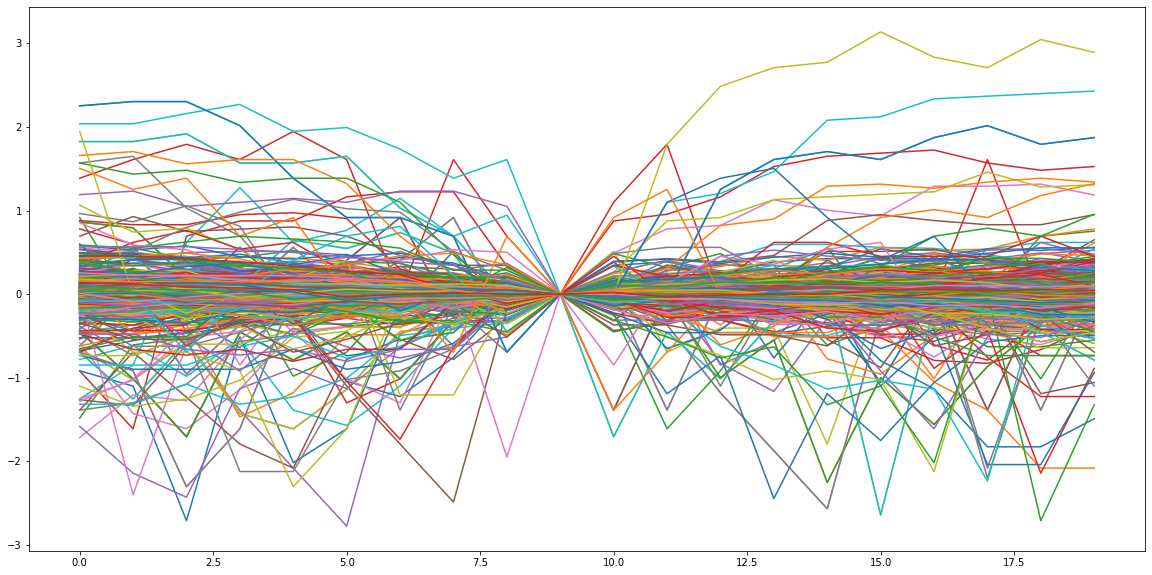

In [10]:
plt.plot(rev_ar.T);

As expected, the revals for most of the speeches are quite flat, while on the other hand there are several speeches that have long lasting market impact.

## 4. A Quick Look at the Important Speeches

In [11]:
most_impact_article_lst = [rst_lst[i][:2] for i in np.argsort(-rev_ar[:, 12])[:10]]

In [12]:
most_impact_article_lst

[('Refining the Stress Capital Buffer', '20190905'),
 ('Challenges for Monetary Policy', '20190823'),
 ('Brief Remarks', '20160929'),
 ('Trends in Community Bank Performance over the Past 20 Years', '20160929'),
 ('Advancing Macroprudential Policy Objectives', '20150130'),
 ('Legal Opportunities and Challenges in Crafting a Foreclosure Response',
  '20111004'),
 ('Welcoming Remarks', '20150204'),
 ('Tailoring Community Bank Regulation and Supervision', '20150430'),
 ('The Economic Outlook', '20161104'),
 ('Remarks on Monetary Policy', '20150408')]

Not surprisingly, the speech before the rate cut in August, is very important.

## 5. Feature Construction 

Here we would like to first use word bag as representation of each of the article. We also notice the titles may also be important so we should think about a method to generate features from them as well. However, intuitively, it might not be the best idea of treating the words in title and those in the passage alike.   
Here we construct features in title and passage seperately and merge the embedded vector together.

In [13]:
X_df = pd.DataFrame([str2word_bag(itm[2], STOP_CHARS, STOP_WORDS, to_lower=True) for itm in rst_lst]).fillna(0)
X = X_df.values

In [14]:
X_title = pd.DataFrame([str2word_bag(itm[1], STOP_CHARS, STOP_WORDS, to_lower=True) for itm in rst_lst]).fillna(0).values

## 6. Trading Strategy Assumptions

1. We have tradable securities for this predictive signal. 
2. We use the rate for backtesting. Here we assume the duration of such securities meerly change in the testing period (several days)

## 7. Systematic Parameter Search and Back Testing

We understand different combination of the hyperparameter, like how to label the sample, might have diverged result to the trading strategy. Here we use a systematic grid search algo to find some reasonable parameter sets by out of sample returns.

Parameters we would like to test on including: learning_algorithm, training_set_length, target_lag, quantile_for_label

Details of this algorithm can be found in *back_test_utils.py*

Results are listed here

In [15]:
with open("param_results.pkl", "rb") as fp:
    param_rst_lst = pickle.load(fp)

with open("params_str.pkl", "rb") as fp:
    params_lst = pickle.load(fp)

In [16]:
len(param_rst_lst)

60

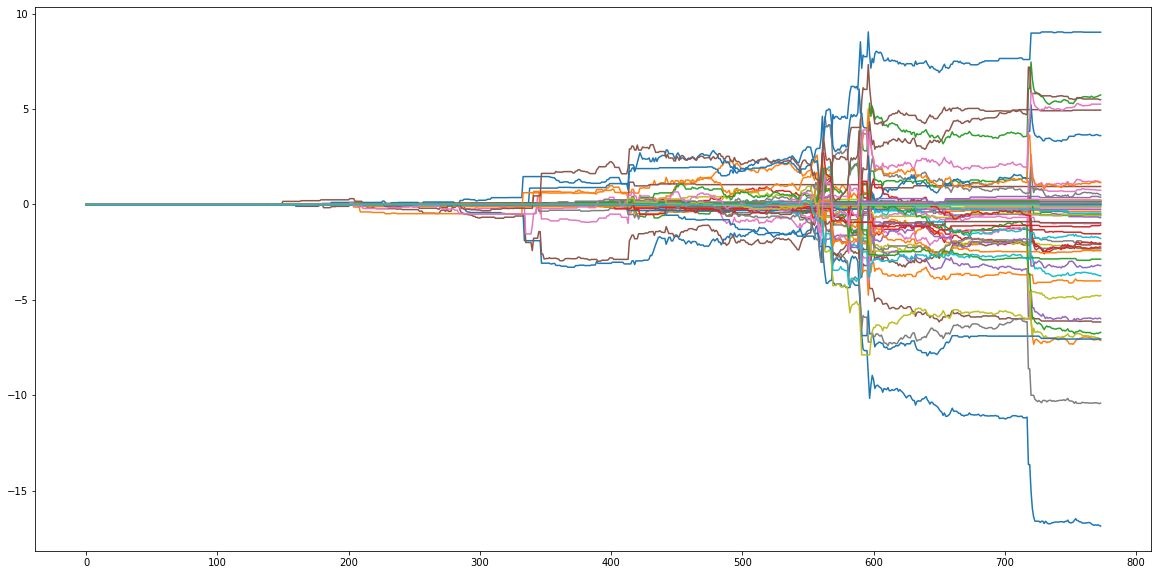

In [17]:
for idx, prd_ar in param_rst_lst:
    plt.plot(np.cumsum((rev_ar[:, 11 + 1] - rev_ar[:, 10]) * prd_ar))

## Best Parameters Sets

In [18]:
rtn_lst = []

for idx, prd_ar in param_rst_lst:
    rtn_lst.append((idx, np.cumsum((rev_ar[:, 11 + 1] - rev_ar[:, 10]) * prd_ar)[-1]))

In [19]:
rtn_lst.sort(key=lambda x: x[1], reverse=True)

In [20]:
rtn_lst[:5]

[(20, 9.02591473914862),
 (12, 5.740265669165892),
 (55, 5.49121370026334),
 (56, 5.254753906979816),
 (35, 4.941780222977251)]

In [21]:
[params for idx, params in enumerate(params_lst) if idx in [i[0] for i in rtn_lst[:10]]]

[('ExtraTreesClassifier(n_estimators=50)',
  'X_df.values',
  'get_y(rev_ar, 1, 20 / 100)',
  200),
 ('ExtraTreesClassifier(n_estimators=50)',
  'X_df.values',
  'get_y(rev_ar, 1, 30 / 100)',
  300),
 ('ExtraTreesClassifier(n_estimators=50)',
  'X_df.values',
  'get_y(rev_ar, 2, 10 / 100)',
  100),
 ('ExtraTreesClassifier(n_estimators=50)',
  'X_df.values',
  'get_y(rev_ar, 2, 20 / 100)',
  100),
 ('ExtraTreesClassifier(n_estimators=50)',
  'X_df.values',
  'get_y(rev_ar, 2, 30 / 100)',
  200),
 ('ExtraTreesClassifier(n_estimators=50)',
  'X_df.values',
  'get_y(rev_ar, 5, 20 / 100)',
  100),
 ('ExtraTreesClassifier(n_estimators=50)',
  'X_df.values',
  'get_y(rev_ar, 5, 30 / 100)',
  100),
 ('ExtraTreesClassifier(n_estimators=50)',
  'X_df.values',
  'get_y(rev_ar, 5, 30 / 100)',
  200),
 ('ExtraTreesClassifier(n_estimators=50)',
  'X_df.values',
  'get_y(rev_ar, 10, 30 / 100)',
  100),
 ('ExtraTreesClassifier(n_estimators=50)',
  'X_df.values',
  'get_y(rev_ar, 10, 30 / 100)',
  200)

Counter intuitively, the titles are more noise than helpful features and the Random Forest models are uniformly better.

In [22]:
y_prd = param_rst_lst[20][1]

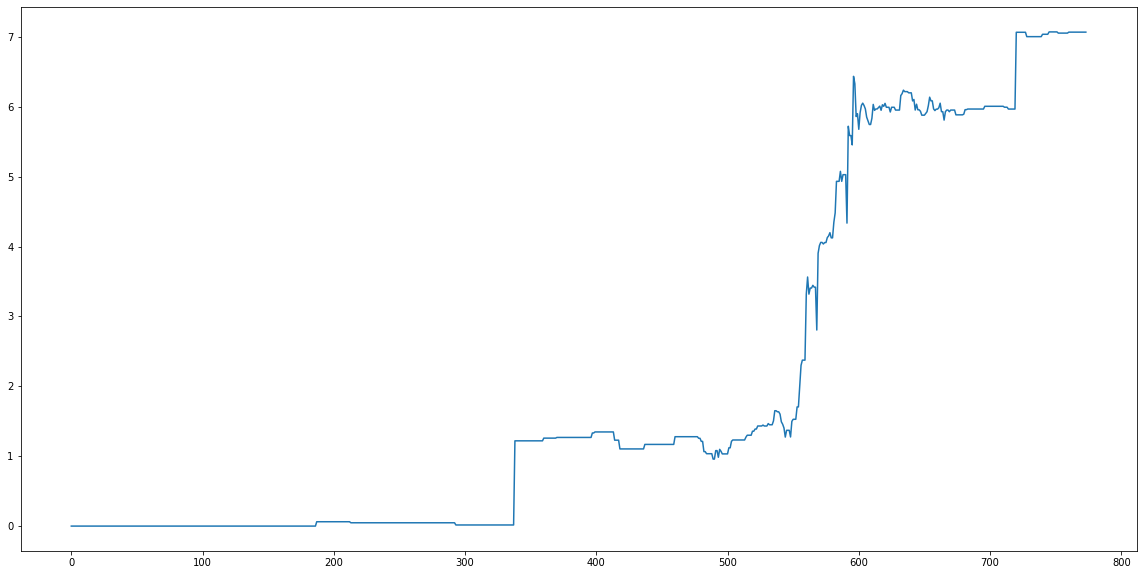

In [23]:
rtn_shift = 1

plt.plot(np.cumsum((rev_ar[:, 9 + 1 + rtn_shift] - rev_ar[:, 9 + rtn_shift]) * y_prd));

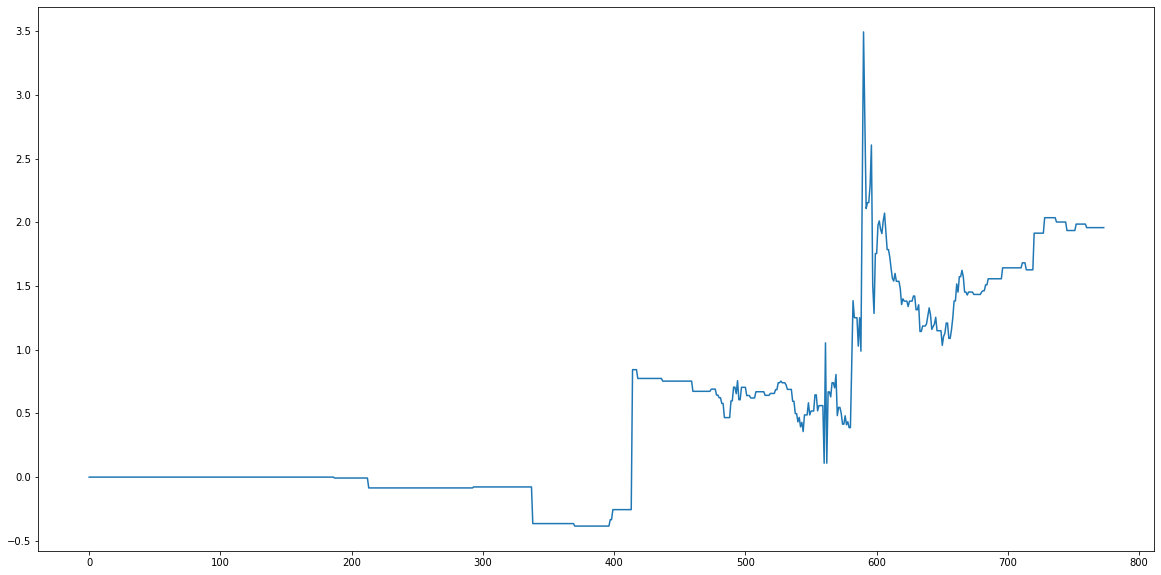

In [24]:
rtn_shift = 2

plt.plot(np.cumsum((rev_ar[:, 9 + 1 + rtn_shift] - rev_ar[:, 9 + rtn_shift]) * y_prd));

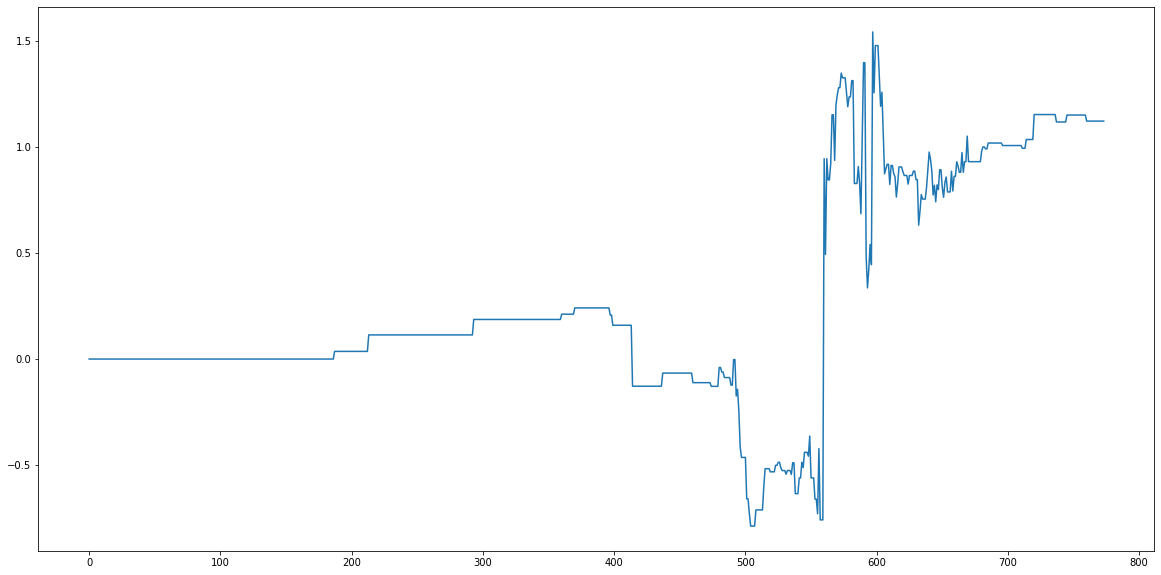

In [25]:
rtn_shift = 3

plt.plot(np.cumsum((rev_ar[:, 9 + 1 + rtn_shift] - rev_ar[:, 9 + rtn_shift]) * y_prd));

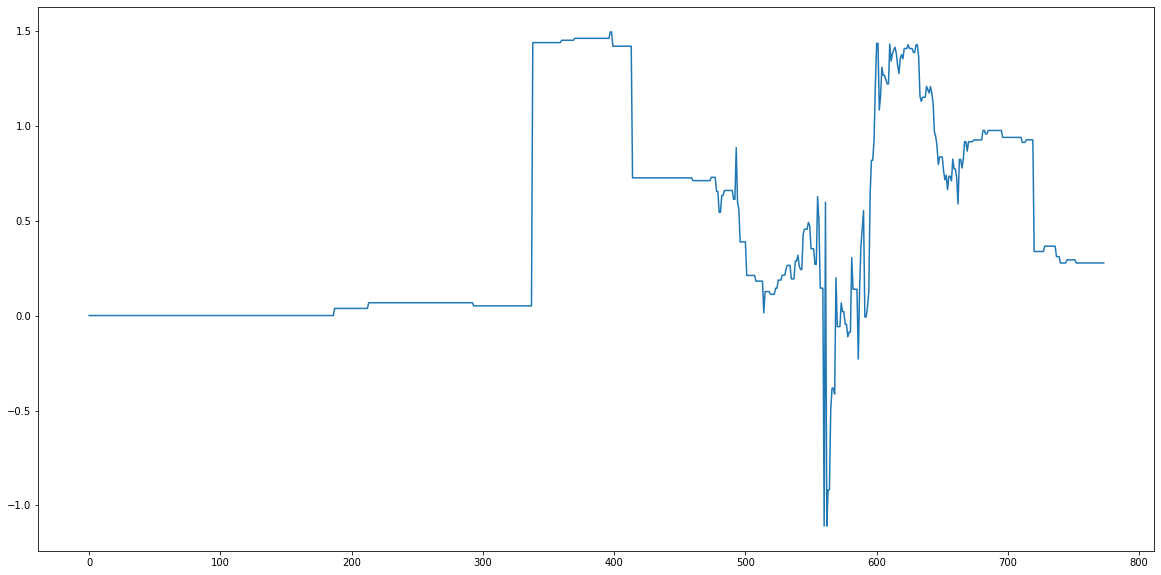

In [26]:
rtn_shift = 4

plt.plot(np.cumsum((rev_ar[:, 9 + 1 + rtn_shift] - rev_ar[:, 9 + rtn_shift]) * y_prd));

## 8. Alpha Decay

In [27]:
mean_decay = get_alpha_decay(rev_ar, y_prd)

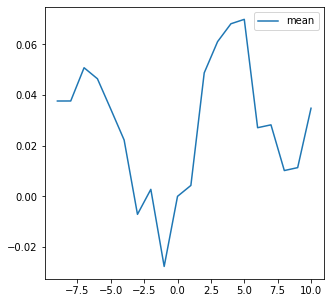

In [34]:
fig = plt.figure(figsize=(5, 5))
plt.plot(range(-9, 11), mean_decay, label="mean")
plt.legend();

# Stage two, classification

In [38]:
from sklearn.cluster import *

In [39]:
from sklearn.decomposition import PCA

In [40]:
X.shape

(774, 33188)

In [41]:
X_trans = PCA(500).fit_transform(X)

In [42]:
clst_model = Birch(n_clusters=2)

In [43]:
clst_model.fit(X)

Birch(branching_factor=50, compute_labels=True, copy=True, n_clusters=2,
      threshold=0.5)

In [44]:
y_clst = clst_model.predict(X)

In [45]:
y_clst

array([0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0,
       0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0,
       1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0,
       0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0,
       1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0,
       1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0,
       0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1,
       0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,
       1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0,
       0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0,
       0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0,
       0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,

In [46]:
#### 1. 检查聚类是否有意义
#### 2. 如果有意义，在每个类别中分别建立NB模型，看单词权重，是否相同？
#### 3. 编写算法，筛选特征（信息熵 e.g.)

In [47]:
ztype_title_lst = [rst_lst[i][:2] for i in np.where(y_clst == 0)[0]]

In [48]:
ztype_title_lst[-20:]

[('Progress on the Transition to Risk-Free Rates', '20190410'),
 ('Fostering Closer Supervisory Communication', '20190402'),
 ('The Financial Stability Board: Beyond the Fog of Battle', '20190402'),
 ('Frameworks for the Countercyclical Capital Buffer ', '20190329'),
 ('Agriculture and Community Banking', '20190328'),
 ('Global Shocks and the U.S. Economy', '20190328'),
 ('The Financial Stability Board in 2019', '20190328'),
 ('Welcoming Remarks', '20190325'),
 ('The Community Reinvestment Act: How Can We Preserve What Works and Make it Better?',
  '20190312'),
 ('Brief Remarks', '20190311'),
 ('Recent Economic Developments and Longer-Term Challenges', '20190228'),
 ('U.S. Economic Outlook and Monetary Policy', '20190228'),
 ('Is Economics for Me? Increasing the Participation of Black Women in Economics',
  '20190223'),
 ('Encouraging Economic Development in High-Poverty Rural Communities',
  '20190212'),
 ('A Conversation on Community Banking', '20190211'),
 ('Ideas of Order: Charting

In [49]:
mean_vec_0 = np.mean(X[np.where(y_clst == 0), :], axis=1)

In [50]:
mean_vec_1 = np.mean(X[np.where(y_clst == 1), :], axis=1)

In [54]:
imp_wds = np.argsort(-np.abs(mean_vec_0 - mean_vec_1))[:, :20]

In [55]:
X_df.columns[imp_wds]

Index([['inflation', 'policy', 'rate', 'monetary', 'federal', 'prices', 'rates', 'economic', 'economy', 'central', 'interest', 'expectations', 'price', 'percent', 'growth', 'capital', 'fomc', 'funds', 'low', 'employment']], dtype='object')

In [57]:
Xy_df = X_df.copy()
Xy_df["y"] = y_clst

In [60]:
Xy_df.iloc[:, imp_wds[0].tolist() + [-1]].groupby("y").mean().to_excel("cluster_discriminant.xlsx")

In [61]:
one_title_lst = [rst_lst[i][:2] for i in np.where(y_clst == 1)[0]]

In [62]:
one_title_lst[-20:]

[('Navigating the Different Signals from Inflation and Unemployment',
  '20170530'),
 ('From Adding Accommodation to Scaling It Back', '20170303'),
 ('Transitions in the Outlook and Monetary Policy', '20170301'),
 ('Monetary Policy in a Time of Uncertainty', '20170117'),
 ('Video', '20170117'),
 ('Data Dependence and U.S. Monetary Policy', '20181127'),
 ('Outlook for the U.S. Economy and Monetary Policy', '20181025'),
 ('What Do We Mean by Neutral and What Role Does It Play in Monetary Policy?',
  '20180912'),
 ('Sustaining Full Employment and Inflation around Target', '20180531'),
 ('Challenges for Monetary Policy', '20190823'),
 ("The Federal Reserve's Review of Its Monetary Policy Strategy, Tools, and Communication Practices",
  '20190701'),
 ('Sustaining Maximum Employment and Price Stability', '20190530'),
 ('The Disconnect between Inflation and Employment in the New Normal',
  '20190516'),
 ('Models, Markets, and Monetary Policy', '20190503'),
 ("The Federal Reserve's Review of I

In [63]:
zero_title_lst = [rst_lst[i][:2] for i in np.where(y_clst == 0)[0]]

In [64]:
zero_title_lst[-20:]

[('Progress on the Transition to Risk-Free Rates', '20190410'),
 ('Fostering Closer Supervisory Communication', '20190402'),
 ('The Financial Stability Board: Beyond the Fog of Battle', '20190402'),
 ('Frameworks for the Countercyclical Capital Buffer ', '20190329'),
 ('Agriculture and Community Banking', '20190328'),
 ('Global Shocks and the U.S. Economy', '20190328'),
 ('The Financial Stability Board in 2019', '20190328'),
 ('Welcoming Remarks', '20190325'),
 ('The Community Reinvestment Act: How Can We Preserve What Works and Make it Better?',
  '20190312'),
 ('Brief Remarks', '20190311'),
 ('Recent Economic Developments and Longer-Term Challenges', '20190228'),
 ('U.S. Economic Outlook and Monetary Policy', '20190228'),
 ('Is Economics for Me? Increasing the Participation of Black Women in Economics',
  '20190223'),
 ('Encouraging Economic Development in High-Poverty Rural Communities',
  '20190212'),
 ('A Conversation on Community Banking', '20190211'),
 ('Ideas of Order: Charting

In [65]:
y = (rev_ar[:, 11] - rev_ar[:, 9])
y_bin = (y > 0).astype(int)

In [66]:
cls_model_0 = GaussianNB()

In [67]:
cls_model_1 = GaussianNB()

In [68]:
X_0 = X[np.where(y_clst == 0)[0], :]
y_0 = np.sign(y[np.where(y_clst == 0)[0]])

In [69]:
X_1 = X[np.where(y_clst == 1)[0], :]
y_1 = np.sign(y[np.where(y_clst == 1)[0]])

In [70]:
fit_rst0 = cls_model_0.fit(X_0, y_0)

In [71]:
fit_rst1 = cls_model_1.fit(X_1, y_1)

In [72]:
dir(fit_rst0)

['__abstractmethods__',
 '__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__getstate__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__setstate__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_abc_cache',
 '_abc_negative_cache',
 '_abc_negative_cache_version',
 '_abc_registry',
 '_estimator_type',
 '_get_param_names',
 '_get_tags',
 '_joint_log_likelihood',
 '_partial_fit',
 '_update_mean_variance',
 'class_count_',
 'class_prior_',
 'classes_',
 'epsilon_',
 'fit',
 'get_params',
 'partial_fit',
 'predict',
 'predict_log_proba',
 'predict_proba',
 'priors',
 'score',
 'set_params',
 'sigma_',
 'theta_',
 'var_smoothing']

In [73]:
fit_rst0.class_count_

array([284.,  45., 290.])

In [74]:
fit_rst0.class_prior_

array([0.45880452, 0.0726979 , 0.46849758])

In [75]:
fit_rst0.sigma_.shape

(3, 33188)

In [76]:
X_df.columns

Index(['-', 'ability', 'abroad', 'absence', 'abundant', 'accelerated',
       'access', 'accession', 'accomplishments', 'account',
       ...
       'previewing', 'products--taking', 'regulators--state', 'respectful',
       'retelling', 'standards-development', 'state-based', 'usa--together',
       'usas', 'veer'],
      dtype='object', length=33188)

In [77]:
X_df.columns[np.argsort(-fit_rst0.theta_[0])[:100]]

Index(['financial', 'banks', 'market', 'capital', 'federal', 'risk', 'credit',
       'firms', 'reserve', 'economic', 'system', 'markets', 'bank',
       'important', 'institutions', 'banking', 'policy', 'liquidity', 'crisis',
       'risks', 'community', 'regulatory', 'percent', 'time', 'mortgage',
       'business', 'large', 'economy', 'years', 'recent', 'growth', 'rate',
       'stability', 'stress', 'assets', 'basel', 'lending', 'information',
       'loans', 'rates', 'monetary', 'requirements', 'small', 'central',
       'management', 'funding', 'provide', 'potential', 'data', 'interest',
       'housing', 'securities', 'work', 'prices', 'regulation', 'make',
       'funds', 'supervisory', 'development', 'past', 'states', 'public',
       'inflation', 'current', 'conditions', 'approach', 'including', 'role',
       'today', 'year', 'standards', 'united', 'investors', 'part',
       'consumers', 'significant', 'borrowers', 'continue', 'global',
       'businesses', 'number', 'syste

In [78]:
X_df.columns[np.argsort(-fit_rst0.theta_[1])[:100]]

Index(['financial', 'banks', 'risk', 'market', 'federal', 'capital',
       'community', 'credit', 'reserve', 'policy', 'institutions', 'percent',
       'bank', 'work', 'markets', 'banking', 'important', 'economic', 'risks',
       'time', 'system', 'years', 'regulatory', 'business', 'growth',
       'economy', 'recent', 'stress', 'rate', 'firms', 'large', 'management',
       'stability', 'information', 'make', 'monetary', 'mortgage',
       'development', 'crisis', 'inflation', 'number', 'lending',
       'communities', 'liquidity', 'securities', 'assets', 'loans', 'year',
       'past', 'today', 'rates', 'regulation', 'consumer', 'labor', 'high',
       'basel', 'increase', 'supervisory', 'products', 'standards', 'data',
       'agencies', 'rules', 'investment', 'prices', 'part', 'cra', 'workers',
       'provide', 'good', 'continue', 'conditions', 'potential', 'activities',
       'committee', 'requirements', 'board', 'future', 'tests', 'guidance',
       'consumers', 'housing', '

In [79]:
X_df.columns[np.argsort(-fit_rst0.theta_[2])[:100]]

Index(['financial', 'banks', 'federal', 'market', 'capital', 'risk', 'reserve',
       'bank', 'policy', 'credit', 'economic', 'banking', 'institutions',
       'system', 'community', 'markets', 'firms', 'important', 'growth',
       'crisis', 'economy', 'percent', 'regulatory', 'rate', 'risks', 'large',
       'years', 'time', 'liquidity', 'monetary', 'recent', 'states',
       'business', 'rates', 'united', 'work', 'loans', 'lending', 'interest',
       'information', 'stability', 'management', 'assets', 'mortgage', 'make',
       'potential', 'central', 'inflation', 'global', 'requirements',
       'including', 'basel', 'regulation', 'significant', 'today', 'labor',
       'prices', 'year', 'funds', 'continue', 'part', 'supervisory', 'data',
       'past', 'public', 'increase', 'current', 'conditions', 'organizations',
       'number', 'standards', 'provide', 'small', 'stress', 'loan',
       'countries', 'board', 'businesses', 'economies', 'real', 'housing',
       'investment', 'p

In [80]:
y2 = Birch(n_clusters=4).fit_predict(X)

In [81]:
np.histogram(y2)

(array([201,   0,   0, 140,   0,   0, 418,   0,   0,  15], dtype=int64),
 array([0. , 0.3, 0.6, 0.9, 1.2, 1.5, 1.8, 2.1, 2.4, 2.7, 3. ]))

In [82]:
def test_cluster_nums(itr, model, X):
    rst_lst = []
    for n in tqdm(itr):
        y = model(n_clusters=n).fit_predict(X)
        
        mean_vec = np.zeros((n, X.shape[1]))
        inner_group_var = np.zeros((n, X.shape[1]))
        for i in range(n):
            mean_vec[i, :] = np.mean(X[y == i, :], axis=0)
            inner_group_var[i, :] = np.var(X[y == i, :], axis=0)
            
        
        between_group = np.var(mean_vec, axis=0)
        rst_lst.append((n, np.sum(between_group) / np.sum(inner_group_var)))
    
    return rst_lst

In [90]:
n_test_rst = test_cluster_nums(range(2, 10), Birch, X)

100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [01:59<00:00, 14.94s/it]


In [92]:
pd.DataFrame(n_test_rst).to_clipboard()

In [83]:
y_cl = Birch(n_clusters=5).fit_predict(X)

In [84]:
X2 = np.hstack((X, y_cl.reshape(-1, 1)))

In [85]:
from sklearn.ensemble import *
from sklearn.svm import *

In [86]:
model1 = ExtraTreesClassifier()
model1.fit(X, y_bin)
y1_prd = model1.predict(X)

C:\Users\hoore\Miniconda3\envs\nlp\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


In [87]:
f1_score(y_bin, y1_prd)

1.0

In [88]:
model2 = ExtraTreesClassifier()
model2.fit(X2, y_bin)
y2_prd = model2.predict(X2)

C:\Users\hoore\Miniconda3\envs\nlp\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


In [89]:
f1_score(y_bin, y2_prd)

1.0